In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Utils
from pyshaper.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event


# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

2024-01-08 19:04:52.243265: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Using CPU!


/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


(1, 625, 3)
(1, 625, 3)


/tmp/ipykernel_15305/3587959624.py:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)


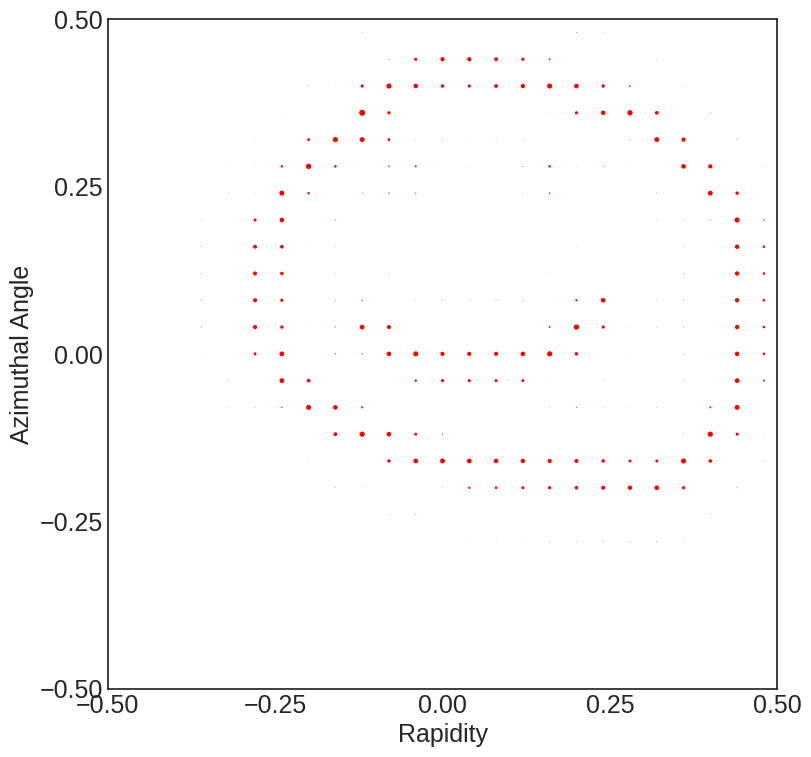

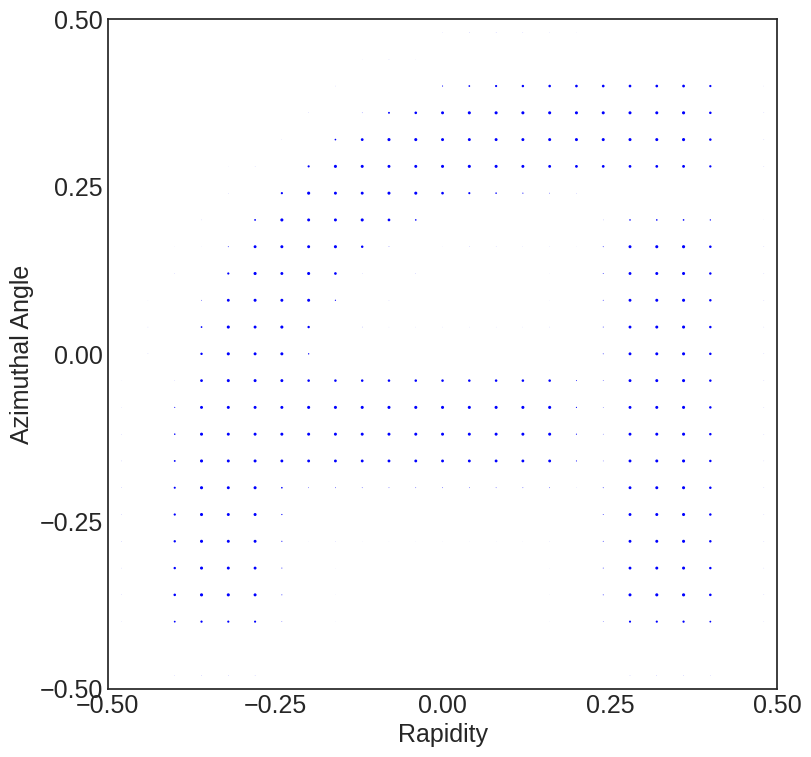

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [6]:
from PIL import Image

# Parameters
R = 0.5
beta = 1.0
N = 50
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

image_1_loc = "images/teehee.png"
image_2_loc = "images/iaifi.png"


def convert_image_to_array(image_path):
    # Load the image
    with Image.open(image_path) as img:
        # Calculate the aspect ratio
        original_width, original_height = img.size
        aspect_ratio = original_width / original_height

        # Calculate new dimensions for downsampling
        # The target is to have at most 625 pixels
        max_pixels = 625
        new_height = int((max_pixels / aspect_ratio) ** 0.5)
        new_width = int(aspect_ratio * new_height)

        # Resize the image
        resized_img = img.resize((new_width, new_height), Image.ANTIALIAS)

        # Convert image to greyscale
        grey_img = resized_img.convert('L')

        # Initialize array
        pixel_array = []

        # Iterate over each pixel in the resized image
        for y in range(new_height):
            for x in range(new_width):
                # Get pixel value (0 to 255)
                pixel_value = grey_img.getpixel((x, y))

                # Normalize intensity (1 for black, 0 for white)
                intensity = 1 - (pixel_value / 255)

                # Normalize x and y coordinates
                norm_x = x / new_width
                norm_y = y / new_height

                # Append to array
                pixel_array.append([intensity, norm_x, norm_y])


        # Normalize intensities to sum to 1
        pixel_array = np.array(pixel_array)
        pixel_array[:,0] = pixel_array[:,0] / np.sum(pixel_array[:,0])

        # Center by subtracting mean x and y
        pixel_array[:,1] = pixel_array[:,1] - np.mean(pixel_array[:,1])
        pixel_array[:,2] = pixel_array[:,2] - np.mean(pixel_array[:,2])

        # flip y
        pixel_array[:,2] = -pixel_array[:,2]

        return pixel_array

image1 = convert_image_to_array(image_1_loc)
image2 = convert_image_to_array(image_2_loc)

# Add extra dimension for batch in the front
image1 = np.expand_dims(image1, axis=0)
image2 = np.expand_dims(image2, axis=0)

print(image1.shape)
print(image2.shape)


plot_event(image1[0,:,1:], image1[0,:,0], R, color = "red")
plot_event(image2[0,:,1:], image2[0,:,0], R, color = "blue")

In [8]:
# Initialize SHAPER
shaper = Shaper({}, device)
shaper.to(device)

# Pairwise EMDS
pairwise_emds = shaper.pairwise_emds2(image1, image1, beta = 1.0, R = R)
print("Pairwise EMDs, should be 0:\n", pairwise_emds)

# Pairwise EMDs with isometry
pairwise_emds2 = shaper.pairwise_emds2(image1, image2, beta = 1.0, R = R)
pairwise_emds_isometry = shaper.pairwise_emds_isometry(image1, image2, beta = 1.0, R = R, lr = 0.075)

print("EMD", pairwise_emds2)
print("EMD modulo isotrometies", pairwise_emds_isometry)

torch.Size([1, 625, 2]) torch.Size([1, 625, 2])
torch.Size([1, 625]) torch.Size([1, 625])
Pairwise EMDs, should be 0:
 [0.]
torch.Size([1, 625, 2]) torch.Size([1, 625, 2])
torch.Size([1, 625]) torch.Size([1, 625])
Epoch 0 Mean Loss = 0.19311201572418213 Elapsed time = 0.548s Percentage done = 0.000 
Epoch 1 Mean Loss = 0.12449576705694199 Elapsed time = 1.115s Percentage done = 0.000 
Epoch 2 Mean Loss = 0.18764153122901917 Elapsed time = 1.657s Percentage done = 0.000 
Epoch 3 Mean Loss = 0.19355827569961548 Elapsed time = 2.171s Percentage done = 0.000 
Epoch 4 Mean Loss = 0.1613101065158844 Elapsed time = 2.662s Percentage done = 0.000 
Epoch 5 Mean Loss = 0.13702134788036346 Elapsed time = 3.171s Percentage done = 0.000 
Epoch 6 Mean Loss = 0.12411351501941681 Elapsed time = 3.654s Percentage done = 0.000 
Epoch 7 Mean Loss = 0.1360679715871811 Elapsed time = 4.142s Percentage done = 0.000 
Epoch 8 Mean Loss = 0.1505589336156845 Elapsed time = 4.704s Percentage done = 0.000 
Epoch 